**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions.

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random
import matplotlib.pyplot as plt

##**Part 1. Building a CNN**

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [121]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

(50000, 32, 32, 3)
(50000, 3, 32, 32)


In [116]:
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

(48000, 3, 32, 32)
(6000, 3, 32, 32)
(48000,)
(6000,)



Next we will construct a **Base Model**, which in our case is a small CNN.

In [77]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns.



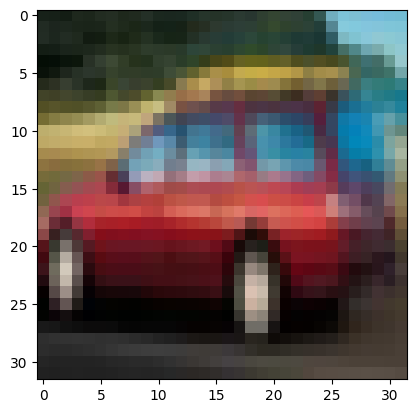

In [6]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0)[:,:,:])

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output.

In [78]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

print(my_image.shape)
#(1,3,32,32)
print(filter_weights.shape)
#(1,1,3,2)
print(my_image[0,0,0,0])

Filter weights: [[[[-0.1387026   0.48467103]
   [ 1.1137451  -0.14566903]
   [ 0.22530891  0.6104454 ]]]]
Conv output: [[[[0.15371041 0.14900315 0.1339978  ... 0.9547983  0.9476447
    0.94553787]
   [0.200783   0.17287907 0.1810704  ... 0.97741705 0.9821933
    0.977486  ]
   [0.20549026 0.1772467  0.2046067  ... 0.98163146 0.98871875
    0.97813123]
   ...
   [0.20711946 0.19770494 0.19770494 ... 0.26433697 0.26904422
    0.28316602]
   [0.17416865 0.16475412 0.16475412 ... 0.29258054 0.2878733
    0.2878733 ]
   [0.1553396  0.15063234 0.1553396  ... 0.35848218 0.35377494
    0.33965313]]

  [[0.08471173 0.0809884  0.06742454 ... 0.64057755 0.6234773
    0.6143949 ]
   [0.12194496 0.10389959 0.10465776 ... 0.65889364 0.64593184
    0.6422085 ]
   [0.12566829 0.10332834 0.12327438 ... 0.66456    0.6544854
    0.65289104]
   ...
   [0.16382621 0.15637958 0.15637958 ... 0.21713765 0.22086097
    0.23203094]
   [0.13776295 0.13031632 0.13031632 ... 0.23947757 0.23575425
    0.23575425]
 

In [8]:
conv = Conv2d(my_image)
print(conv[0][0])
print(filter_weights[0,0,0,0])

[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
  -0.7374622 ]
 [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
  -0.7408506 ]
 [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
  -0.7156083 ]
 ...
 [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
  -0.12222939]
 [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
  -0.12483985]
 [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
  -0.15355481]]
0.7304995


**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [9]:
#Solution to the above problem
#assume no bias, no padding, strides = 1

def my_conv_net(my_image, initial_filter_weights):
  "PUT YOUR CODE HERE"
  N, c_in, height, width = my_image.shape
  k_h, k_w, c, c_out = initial_filter_weights.shape
  out_shape = [N, c_out, height, width]
  my_conv_output = np.empty(out_shape)
  for n in range(0, N):
    for c in range(0, c_out):
      for h in range(0, height):
        for w in range(0, width):
          #since there is only batch size of 1 and kernel size is also 1x1
          out = jn.multiply(my_image[n,:,h,w], initial_filter_weights[0,0,:,c])
          my_conv_output[:,c,h,w] = jn.sum(out)
  return my_conv_output

my_conv_output = my_conv_net(my_image, filter_weights)
print(my_conv_output)

[[[[-0.10271907 -0.10010862 -0.09076816 ... -0.7420423  -0.73912489
    -0.73746228]
   [-0.12882358 -0.11180527 -0.11687266 ... -0.73105443 -0.74346107
    -0.74085063]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911373 -0.71740329
    -0.71560836]
   ...
   [-0.11485984 -0.10963892 -0.10963892 ... -0.11178758 -0.11439803
    -0.12222938]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.12745032 -0.12483985
    -0.12483985]
   [-0.08614486 -0.08353443 -0.08614486 ... -0.16399662 -0.16138616
    -0.15355483]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253248  0.7320599
     0.72146261]
   [ 0.14844204  0.12636711  0.1275416  ...  0.7793448   0.76264036
     0.75807607]
   [ 0.15300636  0.12562042  0.15036322 ...  0.7925384   0.7784524
     0.77533197]
   ...
   [ 0.20083013  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.15975127  0.15975127 ...  0.29957128  0.29500696
     0.29500696]
   [ 0.15062262  0.14605829  0.15062262 ...  0.3634

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer.

In [10]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[-0.1400071 ,  0.35388903]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.**



In [11]:
#Create linear layer
Linear_Layer = objax.nn.Linear(my_conv_output.mean((2,3)).shape[-1],1)
Y = Linear_Layer(my_conv_output.mean((2,3)))

w = Linear_Layer.w.value
b = Linear_Layer.b.value

print('Y:',Y,'w:', w, 'b:', b)

Y: [[0.03471544]] w: [[0.74953187]
 [0.39463   ]] b: [0.]


In [12]:
#PUT YOUR CODE HERE
out = jn.sum(jn.multiply(jn.transpose(w),my_conv_output.mean((2,3)))) + b

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [13]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.value -= lr*grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [14]:
def train(train_op, predict, loss_function, EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.86 Validation Accuracy 9.98
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.07
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.93 Validation Accuracy 10.23
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.18 Validation Accuracy 10.60
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.58 Validation Accuracy 10.68
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 10.64 Validation Accuracy 11.47
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.33 Validation Accuracy 11.37
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.39 Validation Accuracy 11.95
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.89 Validation Accuracy 12.07
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.17 Validation

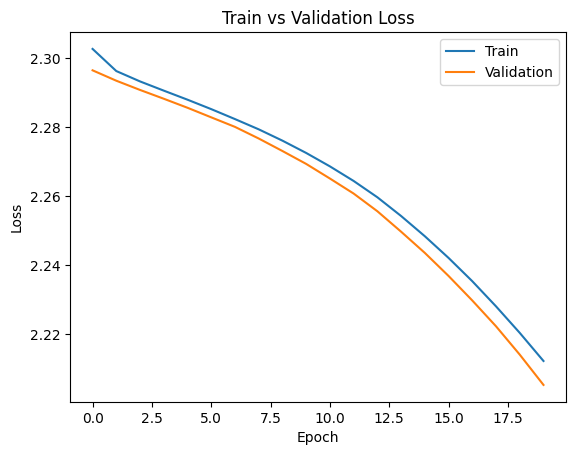

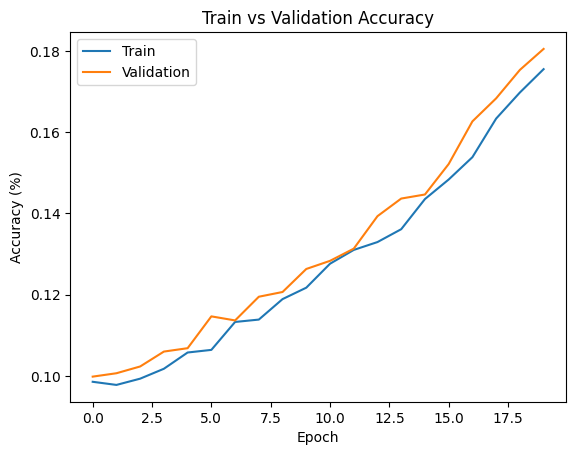

In [35]:
train(train_op, predict, loss_function)

Network M1 with hyperparameters = {32,5e3,30,3} (batch size, learning rate, epochs, number of conv. layers)

In [27]:
class ConvNet1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

model1 = ConvNet1()
def loss_function1(x, labels):
    logit = model1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict1 = objax.Jit(lambda x: objax.functional.softmax(model1(x)), model1.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv1 = objax.GradValues(loss_function1, model1.vars())

#Create an object that can be used to provide trainable variables in the model
tv1 = objax.ModuleList(objax.TrainRef(x) for x in model1.vars().subset(objax.TrainVar))

#Training routine
def train_op1(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv1(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv1.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.value -= lr*grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op1 = objax.Jit(train_op1, gv1.vars() + tv1.vars())

Epoch 0001  Training Loss 2.28 Validation Loss 2.25 Training Accuracy 13.40 Validation Accuracy 16.25
Epoch 0002  Training Loss 2.19 Validation Loss 2.12 Training Accuracy 19.29 Validation Accuracy 20.47
Epoch 0003  Training Loss 2.10 Validation Loss 2.08 Training Accuracy 22.33 Validation Accuracy 22.50
Epoch 0004  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 24.08 Validation Accuracy 22.82
Epoch 0005  Training Loss 2.05 Validation Loss 2.04 Training Accuracy 25.88 Validation Accuracy 23.52
Epoch 0006  Training Loss 2.02 Validation Loss 2.00 Training Accuracy 27.96 Validation Accuracy 25.82
Epoch 0007  Training Loss 1.98 Validation Loss 1.96 Training Accuracy 29.53 Validation Accuracy 28.08
Epoch 0008  Training Loss 1.94 Validation Loss 1.93 Training Accuracy 31.23 Validation Accuracy 29.18
Epoch 0009  Training Loss 1.91 Validation Loss 1.92 Training Accuracy 32.35 Validation Accuracy 28.35
Epoch 0010  Training Loss 1.89 Validation Loss 1.88 Training Accuracy 33.52 Valida

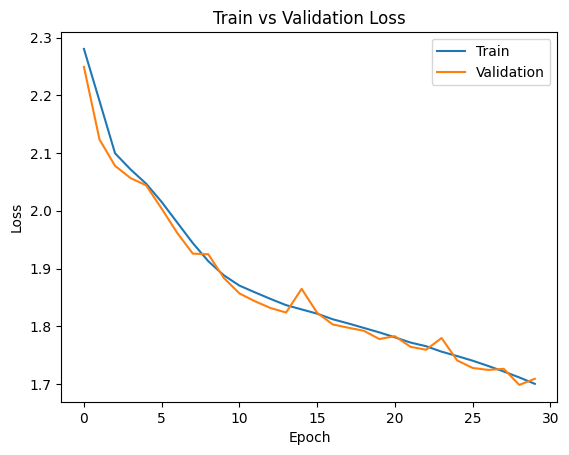

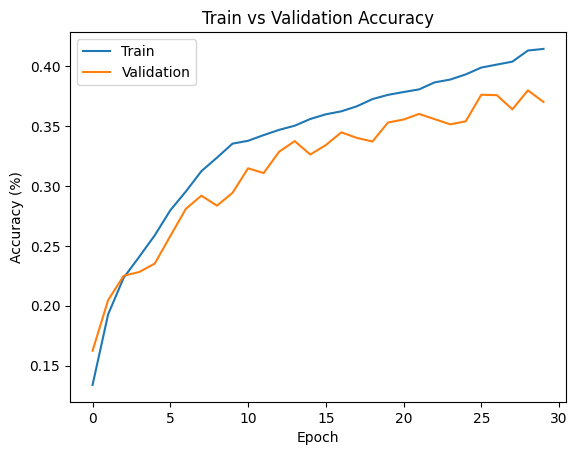

In [28]:
train(train_op1, predict1, loss_function1, EPOCHS=30, LEARNING_RATE = 5e-3)

Network M2 with hyperparameters = {32,1e4,ADAM,4} (batch size, learning rate, optimizer, number of conv. layers)

In [32]:
class ConvNet2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
    self.conv_4 = objax.nn.Sequential([objax.nn.Conv2D(64, 128, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(128, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.conv_4(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

model2 = ConvNet2()
def loss_function2(x, labels):
    logit = model2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict2 = objax.Jit(lambda x: objax.functional.softmax(model2(x)), model2.vars())

adam_optimizer = objax.optimizer.Adam(model2.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv2 = objax.GradValues(loss_function2, model2.vars())

#Create an object that can be used to provide trainable variables in the model
tv2 = objax.ModuleList(objax.TrainRef(x) for x in model2.vars().subset(objax.TrainVar))

#Training routine
def train_op2(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv2(x, y)
    
#update params with adam
    adam_optimizer(lr, gradient)
    
    return loss_value                 # return loss value

#make train_op (much) faster using JIT compilation
train_op2 = objax.Jit(train_op2, gv2.vars() + tv2.vars())

Epoch 0001  Training Loss 1.41 Validation Loss 1.42 Training Accuracy 51.96 Validation Accuracy 47.70
Epoch 0002  Training Loss 1.38 Validation Loss 1.39 Training Accuracy 53.01 Validation Accuracy 49.38
Epoch 0003  Training Loss 1.37 Validation Loss 1.39 Training Accuracy 53.58 Validation Accuracy 49.87
Epoch 0004  Training Loss 1.36 Validation Loss 1.38 Training Accuracy 54.00 Validation Accuracy 49.78
Epoch 0005  Training Loss 1.35 Validation Loss 1.35 Training Accuracy 54.48 Validation Accuracy 50.97
Epoch 0006  Training Loss 1.34 Validation Loss 1.35 Training Accuracy 54.39 Validation Accuracy 51.27
Epoch 0007  Training Loss 1.33 Validation Loss 1.34 Training Accuracy 54.79 Validation Accuracy 51.17
Epoch 0008  Training Loss 1.33 Validation Loss 1.33 Training Accuracy 55.00 Validation Accuracy 51.75
Epoch 0009  Training Loss 1.32 Validation Loss 1.33 Training Accuracy 54.98 Validation Accuracy 52.08
Epoch 0010  Training Loss 1.31 Validation Loss 1.32 Training Accuracy 55.54 Valida

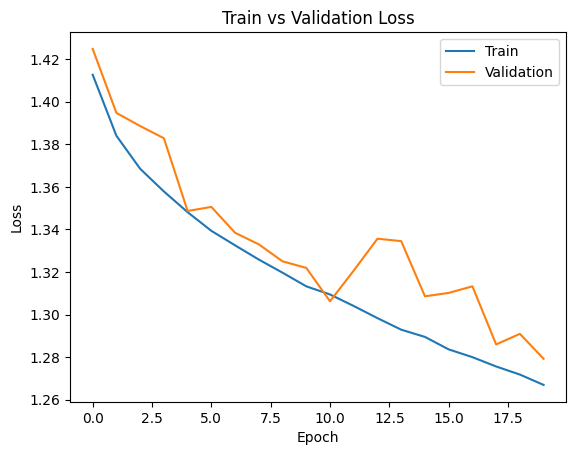

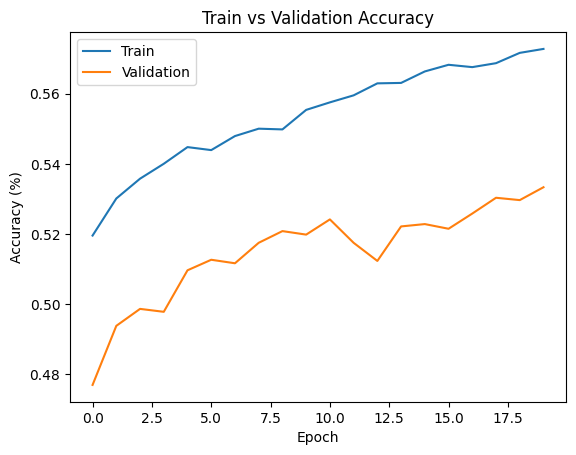

In [34]:
train(train_op2, predict2, loss_function2, BATCH = 32, LEARNING_RATE = 1e-4)

In [36]:
# Inference on the test set using model2
test_predictions = predict2(X_test).argmax(1)

# Get accuracy
accuracy = (test_predictions == Y_test).mean()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 54.35%


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [148]:
#use the other image classification dataset from tf.keras.dataset which is MNIST
from sklearn.model_selection import train_test_split

(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train / 255.0
Y_train = Y_train.flatten()
X_test = X_test / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

#add channel dimension
X_train = np.expand_dims(X_train, axis=1)
X_valid = np.expand_dims(X_valid, axis=1)
X_test = np.expand_dims(X_test, axis=1)

In [149]:
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
#compare with CIFAR dataset which gives these values
#(48000, 3, 32, 32)
#(6000, 3, 32, 32)
#(48000,)
#(6000,)

(56000, 1, 28, 28)
(7000, 1, 28, 28)
(56000,)
(7000,)


(1, 28, 28)


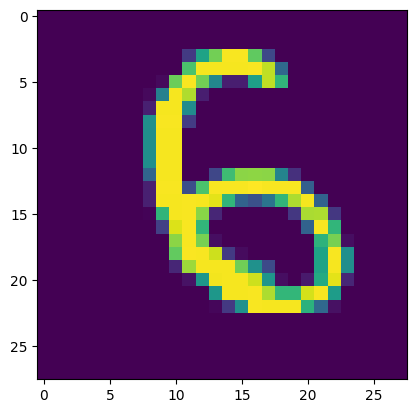

In [150]:
print(X_train[0].shape)
plt.imshow(X_train[0,0])

In [211]:
class baselineModel(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = baselineModel()

objax.io.save_var_collection('model.npz', model.vars())

In [193]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.value -= lr*grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [181]:
def train_model(train_op, predict, loss_function, EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Train Baseline Model

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.05 Validation Accuracy 13.86
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 16.79 Validation Accuracy 17.83
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 19.48 Validation Accuracy 19.03
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 20.41 Validation Accuracy 19.59
Epoch 0005  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 20.56 Validation Accuracy 19.43
Epoch 0006  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 20.55 Validation Accuracy 19.24
Epoch 0007  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 20.82 Validation Accuracy 20.01
Epoch 0008  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 22.68 Validation Accuracy 21.73
Epoch 0009  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 23.69 Validation Accuracy 22.44
Epoch 0010  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 23.95 Valida

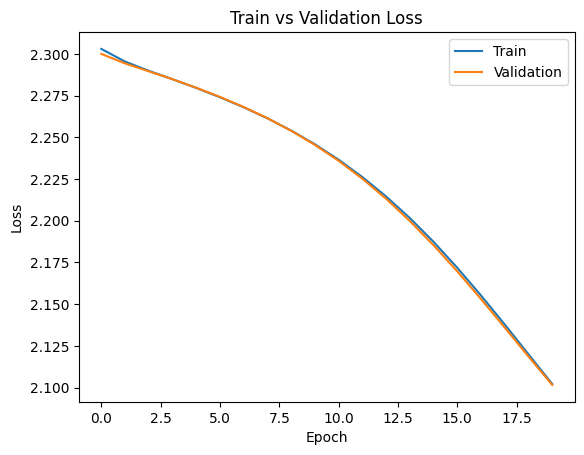

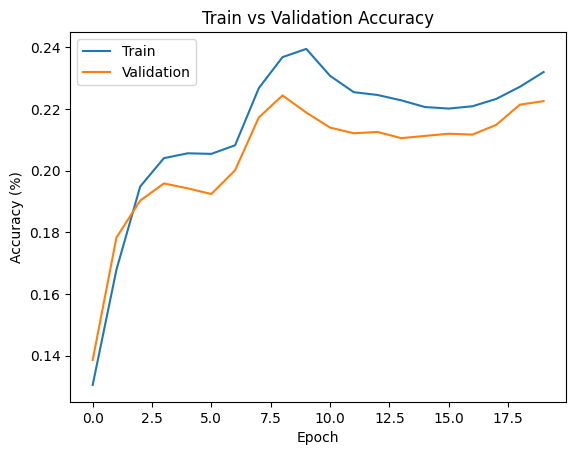

In [154]:
train_model(train_op, predict, loss_function)

Train baseline model with B = 16

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 11.90 Validation Accuracy 17.11
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 19.56 Validation Accuracy 19.51
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 20.43 Validation Accuracy 19.13
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 19.98 Validation Accuracy 18.67
Epoch 0005  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 19.34 Validation Accuracy 18.57
Epoch 0006  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 19.31 Validation Accuracy 18.87
Epoch 0007  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 19.88 Validation Accuracy 19.24
Epoch 0008  Training Loss 2.25 Validation Loss 2.25 Training Accuracy 20.58 Validation Accuracy 20.41
Epoch 0009  Training Loss 2.24 Validation Loss 2.24 Training Accuracy 21.39 Validation Accuracy 21.10
Epoch 0010  Training Loss 2.23 Validation Loss 2.23 Training Accuracy 21.01 Valida

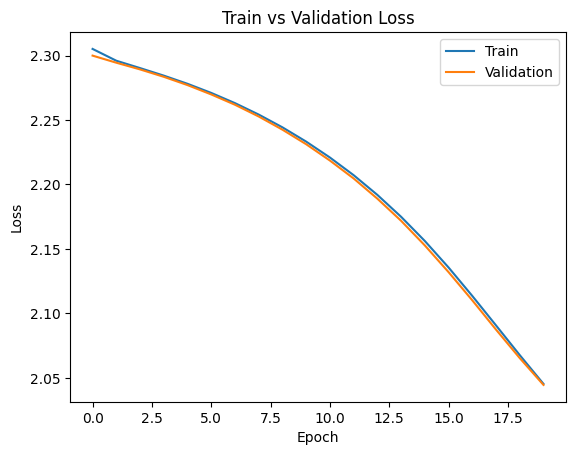

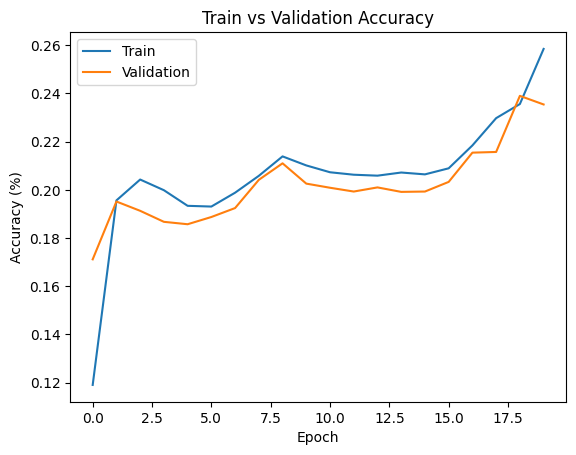

In [182]:
objax.io.load_var_collection('model.npz', model.vars())
#first examine the effects of batch size on training
train_model(train_op, predict, loss_function, BATCH = 16)

Train Baseline Model with B = 24

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 9.73 Validation Accuracy 10.44
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.84 Validation Accuracy 17.63
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 19.63 Validation Accuracy 19.30
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 20.45 Validation Accuracy 19.57
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 20.51 Validation Accuracy 19.63
Epoch 0006  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 20.20 Validation Accuracy 19.26
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 19.90 Validation Accuracy 19.11
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 19.97 Validation Accuracy 19.17
Epoch 0009  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 20.24 Validation Accuracy 19.80
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 20.83 Validat

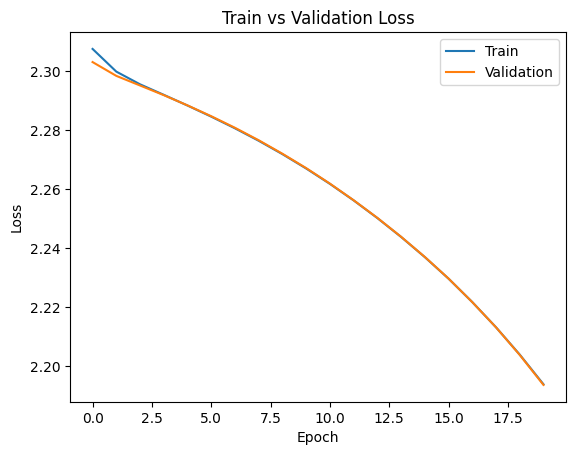

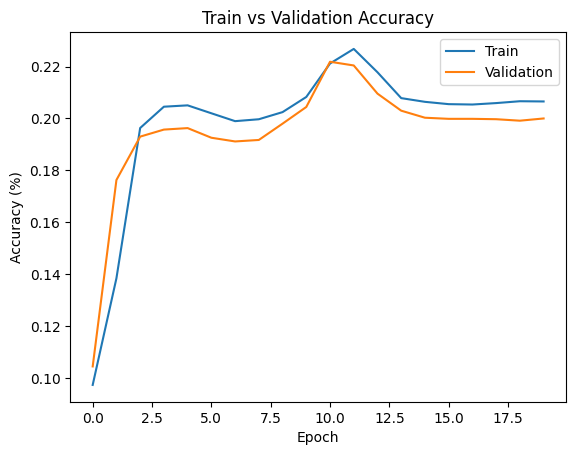

In [183]:
objax.io.load_var_collection('model.npz', model.vars())
train_model(train_op, predict, loss_function, BATCH = 24)

Next, observe the effect of activation functions. Elu, Leaky Relu

In [204]:
#examine the activation function on training
class baselineModel_elu(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.elu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.elu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

model = baselineModel_elu()
objax.io.save_var_collection('model.npz', model.vars())
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())
gv= objax.GradValues(loss_function, model.vars())
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad
    return loss_value                      
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Epoch 0001  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 11.81 Validation Accuracy 9.60
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 8.76 Validation Accuracy 9.44
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.39 Validation Accuracy 9.53
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 11.12 Validation Accuracy 12.23
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 15.44 Validation Accuracy 17.90
Epoch 0006  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 20.66 Validation Accuracy 20.43
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 21.48 Validation Accuracy 20.61
Epoch 0008  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 21.56 Validation Accuracy 20.64
Epoch 0009  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 21.53 Validation Accuracy 20.53
Epoch 0010  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 21.42 Validation

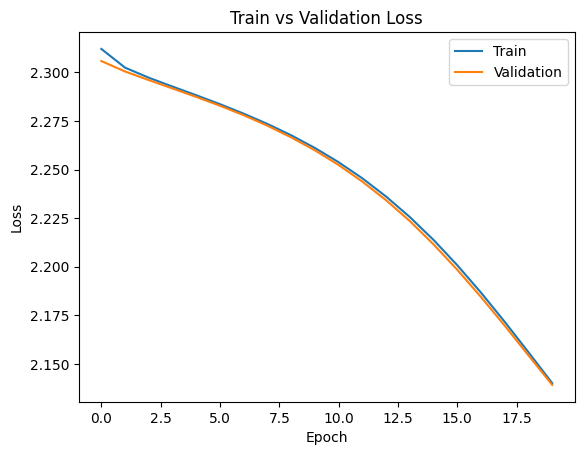

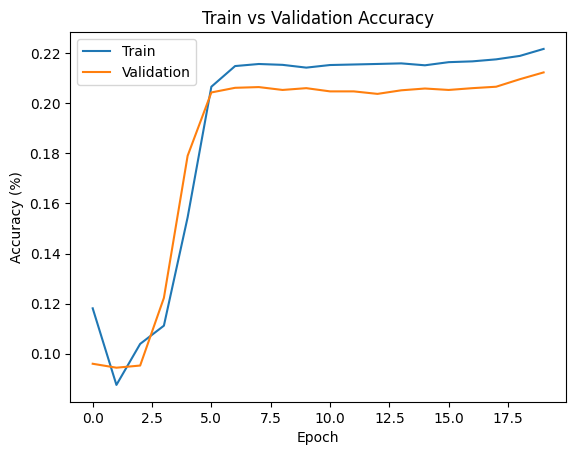

In [205]:
train_model(train_op, predict, loss_function)

In [206]:
class baselineModel_lrelu(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.leaky_relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.leaky_relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

model = baselineModel_lrelu()
#objax.io.save_var_collection('model.npz', model.vars())
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())
gv= objax.GradValues(loss_function, model.vars())
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad
    return loss_value                      
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.87 Validation Accuracy 10.69
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.65 Validation Accuracy 11.71
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.57 Validation Accuracy 14.61
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 14.51 Validation Accuracy 15.07
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 15.41 Validation Accuracy 16.80
Epoch 0006  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 19.19 Validation Accuracy 19.59
Epoch 0007  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 20.38 Validation Accuracy 20.03
Epoch 0008  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 20.68 Validation Accuracy 20.07
Epoch 0009  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 20.70 Validation Accuracy 19.94
Epoch 0010  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 20.69 Valida

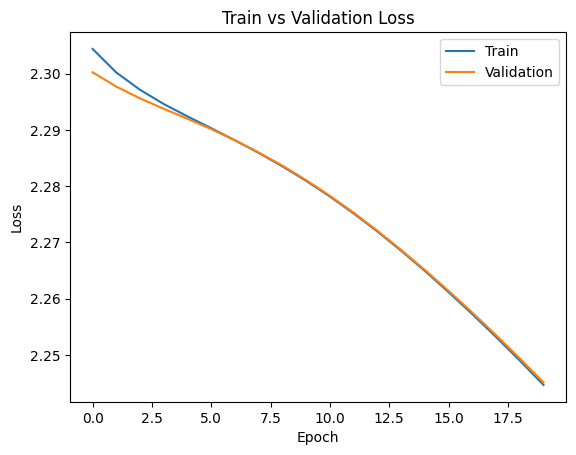

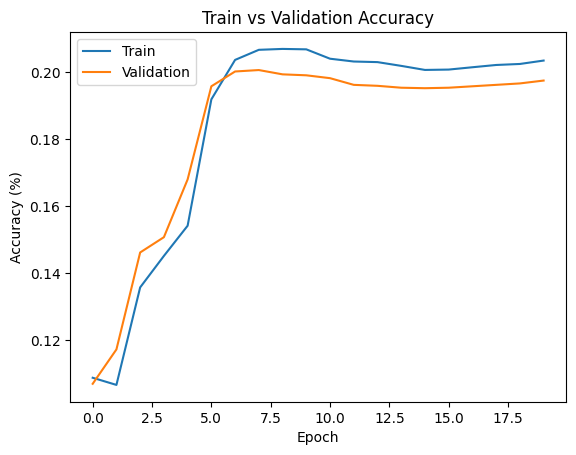

In [207]:
train_model(train_op, predict, loss_function)

Next, test different optimizer: Adam

Epoch 0001  Training Loss 2.09 Validation Loss 1.87 Training Accuracy 24.82 Validation Accuracy 30.89
Epoch 0002  Training Loss 1.73 Validation Loss 1.62 Training Accuracy 39.87 Validation Accuracy 40.84
Epoch 0003  Training Loss 1.54 Validation Loss 1.48 Training Accuracy 46.52 Validation Accuracy 45.76
Epoch 0004  Training Loss 1.41 Validation Loss 1.36 Training Accuracy 52.21 Validation Accuracy 49.14
Epoch 0005  Training Loss 1.32 Validation Loss 1.27 Training Accuracy 56.99 Validation Accuracy 55.04
Epoch 0006  Training Loss 1.24 Validation Loss 1.21 Training Accuracy 59.93 Validation Accuracy 60.17
Epoch 0007  Training Loss 1.18 Validation Loss 1.13 Training Accuracy 62.97 Validation Accuracy 62.77
Epoch 0008  Training Loss 1.13 Validation Loss 1.09 Training Accuracy 65.36 Validation Accuracy 64.11
Epoch 0009  Training Loss 1.09 Validation Loss 1.05 Training Accuracy 67.19 Validation Accuracy 64.59
Epoch 0010  Training Loss 1.05 Validation Loss 1.01 Training Accuracy 69.29 Valida

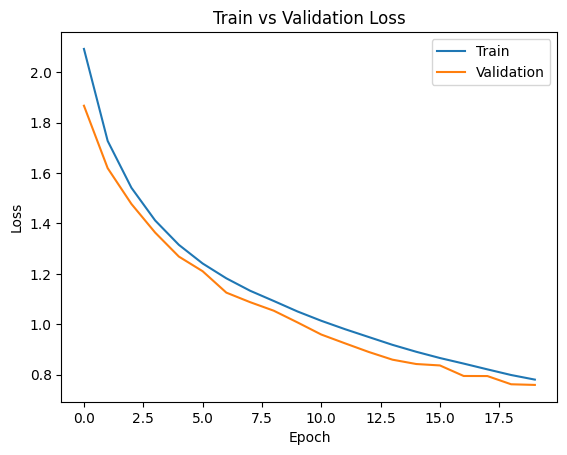

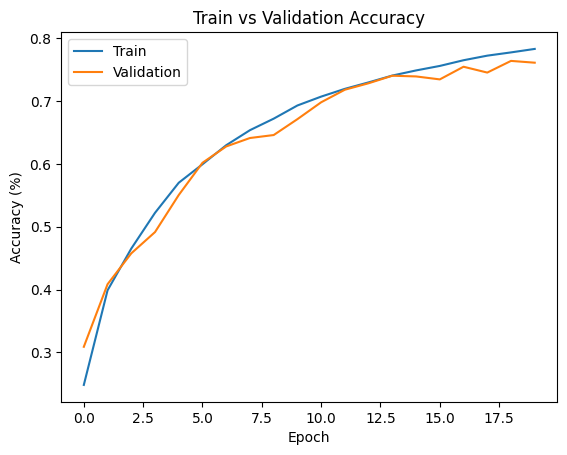

In [212]:
#now test different optimizers
model = baselineModel()
objax.io.load_var_collection('model.npz', model.vars())

adam_optimizer = objax.optimizer.Adam(model.vars())
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())
gv= objax.GradValues(loss_function, model.vars())
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))
def train_op2(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)
#update params with adam
    adam_optimizer(lr, gradient)
    return loss_value   
train_op = objax.Jit(train_op2, gv.vars() + tv.vars())

train_model(train_op, predict, loss_function)

Get the test prediction accuracy of final model. 

In [213]:
# Clearly using the Adam optimizer yields a substantial increase in the validation and training accuracy of the model. 
# We will choose this as the final model, tuning other hyperparameters yield negligable performance boost, though it should be noted that
# certain combinations of different hyperparameters may yield different results from compared to when tested individually
# Determine the testing accuracy of this final model
test_predictions = predict(X_test).argmax(1)

# Get accuracy
accuracy = (test_predictions == Y_test).mean()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 75.99%


In [ ]:
#see other notebook for part 4